# Galaxy Classification with Efficient Vision Transformer (Pytorch)

**Vision Transformer implementation by HuggingFace**:

1. https://huggingface.co/docs/transformers/model_doc/vit#transformers.ViTForImageClassification

2. https://huggingface.co/google/vit-base-patch16-224

3. https://aclanthology.org/2020.emnlp-demos.6/


Data:

https://www.kaggle.com/c/galaxy-zoo-the-galaxy-challenge




## Check GPU

In [ ]:
!nvidia-smi -L

GPU 0: Tesla V100-SXM2-16GB (UUID: GPU-7595e4d1-fd61-1016-08f5-9bc4bca3772c)


## Install Vision Transformer (ViT)

In [ ]:
!pip install transformers

## Import Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, f1_score
import seaborn as sns

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms, utils
import torch.optim as optim
from torch.optim import lr_scheduler

import time
import os
import zipfile
from copy import deepcopy

%matplotlib inline

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# vision transformer
from transformers import ViTModel, ViTConfig, ViTFeatureExtractor, ViTForImageClassification

cuda:0


In [ ]:
torch.manual_seed(0)

## Unzip images


In [ ]:
## The unzipping function
def unzipping(zip_file_name, dest_dir):
    """
    Arguments
        zip_file_name: (str) the file name of the zip file
        dest_dir: (str) the name of the destination folder
    """
    # check if the destination folder exists. Create one if not.
    #if not os.path.exists(dest_dir):
    #    os.makedirs(dest_dir)
    
    # unzipping
    zip_f = zipfile.ZipFile(zip_file_name, 'r')
    zip_f.extractall(path=dest_dir)
    zip_f.close()

#### Unzip from Google Drive

In [ ]:
## directory on Google Drive
datasets_dir = 'drive/MyDrive/gz2_datasets'

## Unzip training, validation, and test images
unzipping(os.path.join(datasets_dir, 'images_train.zip'), './')
unzipping(os.path.join(datasets_dir, 'images_valid.zip'), './')
unzipping(os.path.join(datasets_dir, 'images_test.zip'), './')

## Custom Datasets

In [ ]:
## Custom Galaxy Zoo 2 Dataset
class GalaxyZooDataset(Dataset):
    """Galaxy Zoo Dataset"""

    def __init__(self, csv_file, images_dir, transform=None):
        """
        Args:
            csv_file (string): path to the label csv
            images_dir (string): path to the dir containing all images
            transform (callable, optional): transform to apply
        """
        self.labels_df = pd.read_csv(csv_file)
        self.labels_df = self.labels_df[['galaxyID', 'label1']].copy()

        self.images_dir = images_dir
        self.transform = transform
    
    def __len__(self):
        """
        Returns the size of the dataset
        """
        return len(self.labels_df)

    def __getitem__(self, idx):
        """
        Get the idx-th sample.
		Outputs the image (channel first) and the true label
        """
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        # galaxy ID
        galaxyid = self.labels_df.iloc[idx, 0].astype(str)
		# path of the image
        image_path = os.path.join(self.images_dir, galaxyid + '.jpg')
		# read the image
        image = Image.open(image_path)
		# apply transform (optional)
        if self.transform is not None:
            image = self.transform(image)
		# read the true label
        label = int(self.labels_df.iloc[idx, 1])

        return image, label, int(galaxyid)

## Custom Transforms

In [ ]:
def create_data_transforms(is_for_inception=False):
    """
    Create Pytorch data transforms for the GalaxyZoo datasets.
    Args:
        is_for_inception (bool): True for inception neural networks
    Outputs:
        train_transform: transform for the training data
        test_transform: transform for the testing data
    """
    if is_for_inception:
        input_size = 299
    else:
        input_size = 224

    # transforms for training data
    train_transform = transforms.Compose([transforms.CenterCrop(input_size),
                                          transforms.RandomRotation(90),
                                          transforms.RandomHorizontalFlip(),
                                          transforms.RandomVerticalFlip(),
                                          transforms.RandomResizedCrop(input_size, scale=(0.8, 1.0), ratio=(0.99, 1.01)),
                                          transforms.ToTensor(),
                                          transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])

    # transforms for validation data
    valid_transform = transforms.Compose([transforms.CenterCrop(input_size),
                                          transforms.ToTensor(),
                                          transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])

    # transforms for test data
    test_transform = transforms.Compose([transforms.CenterCrop(input_size),
                                         transforms.ToTensor(),
                                         transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])

    
    return train_transform, valid_transform, test_transform

## Create dataloaders

In [ ]:
"""
Data Loader
"""
# the batch size
BATCH_SIZE = 64

# create transforms
train_transform, valid_transform, test_transform = create_data_transforms(is_for_inception=False)

# create datasets
data_train = GalaxyZooDataset('gz2_train.csv', 'images_train', train_transform)
data_valid = GalaxyZooDataset('gz2_valid.csv', 'images_valid', valid_transform)
data_test = GalaxyZooDataset('gz2_test.csv', 'images_test', test_transform)

# dataloaders
train_loader = DataLoader(data_train, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(data_valid, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(data_test, batch_size=BATCH_SIZE, shuffle=True)

# check the sizes
print("**Dataloaders**")
print("Number of training data: {} ({} batches)".format(len(data_train), len(train_loader)))
print("Number of validation data: {} ({} batches)".format(len(data_valid), len(valid_loader)))
print("Number of test data: {} ({} batches)".format(len(data_test), len(test_loader)))
print("===============================")

**Dataloaders**
Number of training data: 99808 (1560 batches)
Number of validation data: 24952 (390 batches)
Number of test data: 31191 (488 batches)


## Create ViT model

In [ ]:
## hyperparameter
LR = 5e-5
STEP_SIZE = 5
GAMMA = 0.1
MAX_EPOCH = 200
class_weights = torch.FloatTensor([0.19, 0.21, 0.98, 0.38, 0.53, 0.66, 1.81, 3.23]).to(device)

## file name
model_name = "gz2_hug_vit_012322_weighted"

## Vision Transformer
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224')
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224')

print("Number of trainable parameters: {}".format(sum(param.numel() for param in model.parameters() if param.requires_grad)))

# freeze the weights
#for param in model.parameters():
#    param.requires_grad = False

# change the last layer
model.classifier = nn.Linear(in_features=768, out_features=8, bias=True)

print("Number of trainable parameters: {}".format(sum(param.numel() for param in model.parameters() if param.requires_grad)))

Downloading:   0%|          | 0.00/160 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/68.0k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/330M [00:00<?, ?B/s]

Number of trainable parameters: 86567656
Number of trainable parameters: 85804808


## Training Function

In [ ]:
def train_model(model, num_epochs, criterion, optimizer, scheduler, print_every=1, early_stop_epochs=10):
    """
    Train the model
    Args:
        model: Pytorch neural model
        num_epochs: number of epochs to train
        criterion: the loss function object
        optimizer: the optimizer
        scheduler: the learning rate decay scheduler
        print_every: print the information every X epochs
        early_stop_epochs: early stopping if the model doesn't improve after X epochs
    """
    # cache the best model
    best_model_weights = deepcopy(model.state_dict())
    # best train acc
    best_train_acc = 0.0
    # best valid acc
    best_valid_acc = 0.0
    # best epoch
    best_epoch = -1    

    # intiate dict to records the history of loss and acc
    history_dic = dict()
    history_dic['train_loss'] = []
    history_dic['train_acc'] = []
    history_dic['valid_loss'] = []
    history_dic['valid_acc'] = []
    history_dic['lr'] = []

    for epoch in range(num_epochs):
        # time of start
        epoch_start_time = time.time()

        """
        Train
        """
        model.train()

        epoch_train_cum_loss = 0.0
        epoch_train_cum_corrects = 0
        
        for images, labels, _ in train_loader:
            images = images.to(device)
            labels = labels.long().to(device)

            optimizer.zero_grad()
            
            outputs = model(images)
            pred_logits = outputs.logits
            loss = criterion(pred_logits, labels)

            _, pred_classes = torch.max(pred_logits.detach(), dim=1)
            pred_classes = pred_classes.long()

            epoch_train_cum_loss += loss.item() * images.size(0)
            epoch_train_cum_corrects += torch.sum(pred_classes==labels.data).detach().to('cpu').item()

            loss.backward()
            optimizer.step()
            
        """
        Eval
        """
        model.eval()

        epoch_valid_cum_loss = 0.0
        epoch_valid_cum_corrects = 0

        for images, labels, _ in valid_loader:
            images = images.to(device)
            labels = labels.long().to(device)

            with torch.no_grad():
                outputs = model(images)
                pred_logits = outputs.logits
                _, pred_classes = torch.max(pred_logits.detach(), dim=1)
                loss = criterion(pred_logits, labels)

                epoch_valid_cum_loss += loss.item() * images.size(0)
                epoch_valid_cum_corrects += torch.sum(pred_classes==labels.data).detach().to('cpu').item()

        ## Calculate metrics
        train_loss = epoch_train_cum_loss / len(data_train)
        train_acc = epoch_train_cum_corrects / len(data_train)
        valid_loss = epoch_valid_cum_loss / len(data_valid)
        valid_acc = epoch_valid_cum_corrects / len(data_valid)

        # update history_dic
        history_dic['train_loss'].append(train_loss)
        history_dic['train_acc'].append(train_acc)
        history_dic['valid_loss'].append(valid_loss)
        history_dic['valid_acc'].append(valid_acc)
        history_dic['lr'].append(scheduler.get_last_lr()[0])

        # check if is the best acc ever
        if valid_acc > best_valid_acc:
            best_train_acc = train_acc
            best_valid_acc = valid_acc
            best_epoch = epoch + 1
            # update the best model weights
            best_model_weights = deepcopy(model.state_dict())
            # save the best model weights to Google drive
            torch.save(model.state_dict(), os.path.join('drive/MyDrive/gz2_datasets', model_name + "_cache.pth"))

        epoch_end_time = time.time()
        epoch_time_used = epoch_end_time - epoch_start_time
        # convert epoch_time_used into mm:ss
        mm = epoch_time_used // 60
        ss = epoch_time_used % 60

        ## Print metrics
        if (epoch+1) % print_every == 0:

            # if is best valid acc
            if epoch == (best_epoch - 1):
                print("Epoch {}/{}\tTrain loss: {:.4f}\tTrain acc: {:.4f}\tValid loss: {:.4f}\tValid acc: {:.4f}\tTime: {:.0f}m {:.0f}s\t<--".format(
                    epoch+1, num_epochs, train_loss, train_acc, valid_loss, valid_acc, mm, ss))
            # not a better model
            else:
                print("Epoch {}/{}\tTrain loss: {:.4f}\tTrain acc: {:.4f}\tValid loss: {:.4f}\tValid acc: {:.4f}\tTime: {:.0f}m {:.0f}s".format(
                    epoch+1, num_epochs, train_loss, train_acc, valid_loss, valid_acc, mm, ss))
            
        ## Early stopping
        if (epoch+1) - best_epoch >= early_stop_epochs:
            print("Early stopping... (Model did not improve after {} epochs)".format(early_stop_epochs))
            break
        
        scheduler.step()
    
    # load the best weights into the model
    model.load_state_dict(best_model_weights)
    # print the best epoch
    print("Best epoch = {}, with training accuracy = {:.4f} and validation accuracy = {:.4f}".format(best_epoch, best_train_acc, best_valid_acc))

    # return the best model
    return model, history_dic

## Train the model

In [ ]:
# move to gpu
model = model.to(device)

# loss function
criterion = nn.CrossEntropyLoss(weight=class_weights)

# optimizer
optimizer = optim.Adam(model.parameters(), lr=LR)

# scheduler
scheduler = lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

## train and return the best model
model, history_dic = train_model(model, MAX_EPOCH, criterion, optimizer, scheduler, print_every=1, early_stop_epochs=10)

## Save the best weights
torch.save(model.state_dict(), model_name + '.pth')
torch.save(model.state_dict(), os.path.join('drive/MyDrive/gz2_datasets', model_name + '.pth'))

## Convert history to dataframe
history_df = pd.DataFrame(history_dic)

## Save the history
history_df.to_csv(model_name + '_history.csv', index=False)
history_df.to_csv(os.path.join('drive/MyDrive/gz2_datasets', model_name + '_history.csv'), index=False)

Epoch 1/200	Train loss: 0.7663	Train acc: 0.7294	Valid loss: 0.6358	Valid acc: 0.7596	Time: 29m 57s	<--
Epoch 2/200	Train loss: 0.6169	Train acc: 0.7763	Valid loss: 0.6004	Valid acc: 0.7825	Time: 29m 31s	<--
Epoch 3/200	Train loss: 0.5727	Train acc: 0.7886	Valid loss: 0.5863	Valid acc: 0.7573	Time: 29m 25s
Epoch 4/200	Train loss: 0.5410	Train acc: 0.7955	Valid loss: 0.5718	Valid acc: 0.7712	Time: 29m 17s
Epoch 5/200	Train loss: 0.5144	Train acc: 0.8027	Valid loss: 0.5782	Valid acc: 0.8024	Time: 29m 17s	<--
Epoch 6/200	Train loss: 0.4248	Train acc: 0.8305	Valid loss: 0.5314	Valid acc: 0.8181	Time: 29m 29s	<--
Epoch 7/200	Train loss: 0.3989	Train acc: 0.8389	Valid loss: 0.5329	Valid acc: 0.8171	Time: 29m 22s
Epoch 8/200	Train loss: 0.3867	Train acc: 0.8425	Valid loss: 0.5299	Valid acc: 0.8214	Time: 29m 26s	<--
Epoch 9/200	Train loss: 0.3763	Train acc: 0.8455	Valid loss: 0.5409	Valid acc: 0.8164	Time: 29m 28s
Epoch 10/200	Train loss: 0.3660	Train acc: 0.8467	Valid loss: 0.5416	Valid acc: 

## Predict test data

In [ ]:
def predict_model(model):
    """
    Predict test data
    """
    # evaluation
    model.eval()

    # empty lists for results
    y_true = []
    y_pred = []
    y_label = []

    for images, labels, galaxy_id in test_loader:
        images = images.to(device)
        labels = labels.long().to(device)

        with torch.no_grad():
            outputs = model(images)
            pred_logits = outputs.logits
            _, pred_classes = torch.max(pred_logits.detach(), dim=1)

            y_true += torch.squeeze(labels.cpu()).tolist()
            y_pred += torch.squeeze(pred_classes).tolist()
            y_label += torch.squeeze(galaxy_id.cpu()).tolist()
    
    # create a DataFrame with columns 'GalaxyID', 'class', 'predicted labels'
    predict_df = pd.DataFrame(data={'GalaxyID': y_label, 'class': y_true, 'pred': y_pred})

    return y_true, y_pred, predict_df

In [ ]:
# move to gpu
model = model.to(device)

# model evaluation
y_true, y_pred, predict_df = predict_model(model)

# save predict_df
predict_df.to_csv(model_name + '_predictions.csv', index=False)
predict_df.to_csv(os.path.join('drive/MyDrive/gz2_datasets', model_name + '_predictions.csv'), index=False)

In [ ]:
predict_df.head()

,GalaxyID,class,pred
0,143913,1,1
1,163557,5,0
2,30960,1,1
3,269806,5,5
4,274023,1,1


## Evaluation metrics


Class 0: accuracy = 0.8580 (Round Elliptical)
Class 1: accuracy = 0.8083 (In-between Elliptical)
Class 2: accuracy = 0.8552 (Cigar-shaped Elliptical)
Class 3: accuracy = 0.8446 (Edge-on Spiral)
Class 4: accuracy = 0.8257 (Barred Spiral)
Class 5: accuracy = 0.8267 (Unbarred Spiral)
Class 6: accuracy = 0.7253 (Irregular)
Class 7: accuracy = 0.7740 (Merger)
Total Accuracy = 0.8275

Recall = 0.8147

F1 score = 0.7836



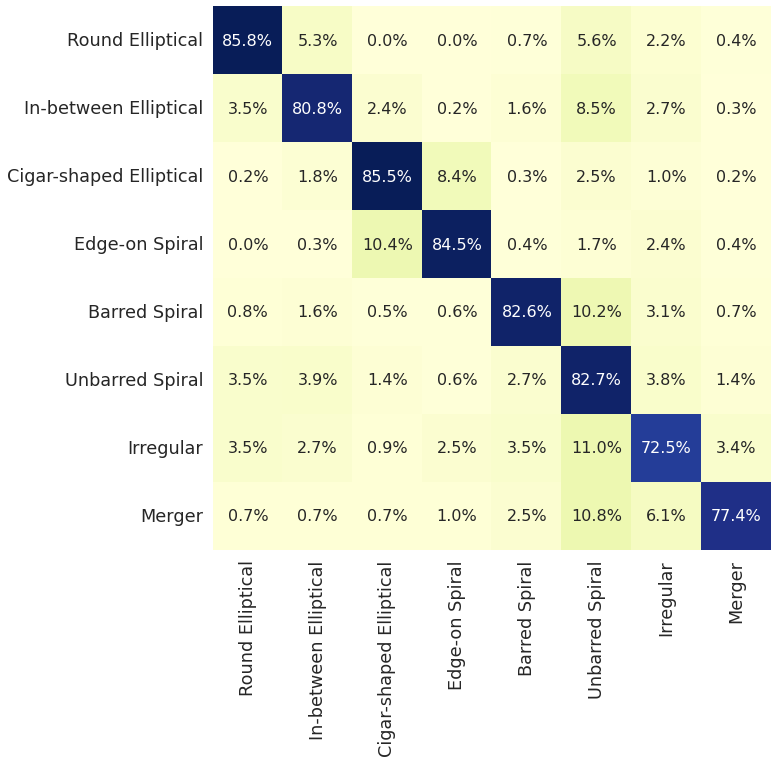

In [ ]:
# galaxy classes
gxy_labels = ['Round Elliptical',
              'In-between Elliptical',
              'Cigar-shaped Elliptical',
              'Edge-on Spiral',
              'Barred Spiral',
              'Unbarred Spiral',
              'Irregular',
              'Merger']

# confusion matrix
cm = confusion_matrix(y_true, y_pred, normalize='true')
cm_df = pd.DataFrame(cm, index=gxy_labels, columns=gxy_labels)

# accuracy of each class
for c in range(8):
    print("Class {}: accuracy = {:.4f} ({})".format(c, cm[c,c]/sum(cm[c,:]), gxy_labels[c]))
print("================")

# accuracy
acc = accuracy_score(y_true, y_pred)
print("Total Accuracy = {:.4f}\n".format(acc))

# recall
recall = recall_score(y_true, y_pred, average='macro')
print("Recall = {:.4f}\n".format(recall))

# f1 score
F1 = f1_score(y_true, y_pred, average='macro')
print("F1 score = {:.4f}\n".format(F1))

# plot confusion matrix
sns.set(font_scale=1.6)
fig = plt.figure(figsize=(10, 10))
sns.heatmap(cm_df, annot=True, fmt=".1%", cmap="YlGnBu", cbar=False, annot_kws={"size": 16})
plt.show()